In [2]:
#Set up DrWatson
cd("/home/jm2386/Active_Lattice/")
using DrWatson
@quickactivate "Active_Lattice"
# Load relevant fuctions
include("/home/jm2386/Active_Lattice/src/pm_pde_functions.jl");
include("/home/jm2386/Active_Lattice/src/Hetrocline.jl");
include("/home/jm2386/Active_Lattice/src/plot_functions.jl");

function animate_phase_pdes_pm(param,t_saves,fa_saves,fp_saves; frames = 99, ϕg = 0.0, ϕl = 1.0)
    @unpack name, λ, ρa, ρp, Nx, Nθ, δt, Dθ, χ, γ = param
    fig, axs = plt.subplots(2, 1, figsize=(10,10))
    N = length(t_saves)
    function makeframe(i)
        clf()
        ax1 = fig.add_subplot(211)
        ax2 = fig.add_subplot(212)
        axs = ax1, ax2
        vid_pde_plot_pm(fig, axs, param, t_saves, fa_saves, fp_saves, i+1)
        binod_liquid = ax1.plot((1:Nx)/Nx, ϕl*ones(Nx), color = "black", linestyle = "--", label = "_liquid phase")
        binod_gas = ax1.plot((1:Nx)/Nx, ϕg*ones(Nx), color = "black",linestyle = "--", label = "_gas phase")
        return fig
    end
    interval = 5*Int64(round(20000/frames))
    myanim = anim.FuncAnimation(fig, makeframe, frames=frames, interval=interval)
    # Convert it to an MP4 movie file and saved on disk in this format.
    T = t_saves[Int64(round((frames+1)))]
    pathname = "/store/DAMTP/jm2386/Active_Lattice/plots/vids/pde_phase_vids/$(name)/active=$(ρa)_passive=$(ρp)_lamb=$(λ)";
    mkpath(pathname)
    filename = "/store/DAMTP/jm2386/Active_Lattice/plots/vids/pde_phase_vids/$(name)/active=$(ρa)_passive=$(ρp)_lamb=$(λ)/time=$(round(T; digits = 5))_Nx=$(Nx)_Nθ=$(Nθ)_active=$(ρa)_passive=$(ρp)_lamb=$(λ).mp4";
    myanim[:save](filename, bitrate=-1, dpi= 100, extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"])
end

function make_phase_video_pm(param; skip_factor = 10, ϕg = 0.0, ϕl = 1.0,start_time = 0.)
    @unpack T, save_interval = param
    save_interval = save_interval*skip_factor
    t_saves, fa_saves, fp_saves = load_pdes_pm(param,T; save_interval = save_interval, start_time = start_time)
    frames = Int64(length(t_saves))
    animate_phase_pdes_pm(param,t_saves,fa_saves,fp_saves; frames = frames-1,ϕg =ϕg, ϕl = ϕl)
end

function vid_pde_plot_pm(fig::Figure, axs, param::Dict{String,Any}, t_saves, fa_saves, fp_saves, i)
    @unpack Nx, Nθ, ρa, ρp, χ, Dθ, Dx, k, γ,Pe = param
    ρa_saves, ρp_saves = deepcopy(spatial_density_pm.(fa_saves)), deepcopy(fp_saves)

    push!(ρa_saves[i], ρa_saves[i][1])
    push!(ρp_saves[i], ρp_saves[i][1])

    ρsum = ρp_saves[i]+ρa_saves[i]

    axs[1].plot((0:1:Nx)/Nx,ρa_saves[i], color = "red", label = L"\rho^a")
    axs[1].plot((0:1:Nx)/Nx,ρsum, color = "black", label = L"\rho")
    axs[1].plot((0:1:Nx)/Nx,ρp_saves[i], color = "blue", label = L"\rho^p")

    axs[1].xaxis.set_ticks(0.:0.2:1.0)
    axs[1].xaxis.set_tick_params(labelsize=15)
    axs[1].yaxis.set_tick_params(labelsize=15)
    rhomax = maximum(maximum(ρa_saves))+maximum(maximum(ρp_saves))
    axs[1].axis([0., 1., 0. , rhomax])
    #axs[1].axis([0., 1., min(minimum(minimum(ρa_saves)),minimum(minimum(ρp_saves))),maximum(maximum( ρa_saves+ρp_saves ))])
    axs[1].set_xlabel(L"x",fontsize=20)
    #axs[1].set_ylabel(L"\rho,",fontsize=20)
    title = latexstring("\$ \\ell = $(round(1/sqrt(Dθ); digits = 2)), \\chi = $(χ), \\phi = $(ρa+ρp), \\mathrm{Pe} = $(round(Pe; digits = 3)), t = $(round(t_saves[i]; digits = 3))\$")
    axs[1].set_title(title,fontsize=20)

    mat1 = zeros(1, Nx+1)
    mat2= zeros(1, Nx+1)
    mags = mag_pm(fa_saves[i]; Nθ = Nθ)
    push!(mags,mags[1])
    mat1[1, :] = mags
    mat2[1, :] = mags.*(-ρsum.+1)

    #colmap = PyPlot.plt.cm.seismic
    colmap = PyPlot.plt.cm.PRGn
    norm1 = matplotlib.colors.Normalize(vmin= -rhomax*0.5 , vmax= rhomax*0.5) 
    #norm1 = matplotlib.colors.Normalize(vmin= -maximum(abs.(mags)) , vmax= maximum(abs.(mags)) )
    #norm2 = matplotlib.colors.Normalize(vmin= minimum(mags/10) , vmax= maximum(mags)/10 )

    axs[2].matshow(mat1; norm = norm1,  cmap = colmap, extent = [0., 1., 0., 0.1])
    #axs[3].matshow(mat2; norm = norm2,  cmap = colmap, extent = [0., 1., 0., 0.1])

    axs[2].set_aspect(1.)
    #axs[3].set_aspect(1.)

    axs[2].xaxis.set_ticks(0.:0.2:1.0)
    axs[2].yaxis.set_ticks([])
    axs[2].xaxis.set_tick_params(labelsize=15)
    axs[2].xaxis.tick_bottom()
    #ax.set_title(L"\Re{ \lambda_n^\mathrm{max}} = 0",fontsize=20)
    #ax.set_xlabel(L"x",fontsize=20)

    axs[2].set_ylabel(L"\mathbf{p}", fontsize=20, rotation=0)
    axs[2].yaxis.set_label_coords(-.05, .5)

    lines, labels = axs[1].get_legend_handles_labels()
    fig.tight_layout()
    ldg = fig.legend(lines, labels, loc = "center right", fontsize=20, bbox_to_anchor = (0.25, 0.25, 1, 1),
    bbox_transform = plt.gcf().transFigure)

    return fig
end

function vid_pde_plot_pm_plus(fig::Figure, axs, param::Dict{String,Any}, t_saves, fa_saves, fp_saves, i)
    @unpack Nx, Nθ, ρa, ρp, χ, Dθ, Dx, k, γ,Pe = param
    ρa_saves, ρp_saves = deepcopy(spatial_density_pm.(fa_saves)), deepcopy(fp_saves)

    ja_saves, jp_saves = deepcopy(spatial_currents_pm(fa_saves, fp_saves; param = param))

    push!(ja_saves[i], ja_saves[i][1])
    push!(jp_saves[i], jp_saves[i][1])

    push!(ρa_saves[i], ρa_saves[i][1])
    push!(ρp_saves[i], ρp_saves[i][1])

    ρsum = ρp_saves[i]+ρa_saves[i]

    axs[1].plot((0:1:Nx)/Nx,ρa_saves[i], color = "red", label = L"\rho^a")
    axs[1].plot((0:1:Nx)/Nx,ρsum, color = "black", label = L"\rho")
    axs[1].plot((0:1:Nx)/Nx,ρp_saves[i], color = "blue", label = L"\rho^p")

    axs[1].xaxis.set_ticks(0.:0.2:1.0)
    axs[1].xaxis.set_tick_params(labelsize=15)
    axs[1].yaxis.set_tick_params(labelsize=15)
    rhomax = maximum(maximum(ρa_saves))+maximum(maximum(ρp_saves))
    axs[1].axis([0., 1., 0. , rhomax])
    #axs[1].axis([0., 1., min(minimum(minimum(ρa_saves)),minimum(minimum(ρp_saves))),maximum(maximum( ρa_saves+ρp_saves ))])
    axs[1].set_xlabel(L"x",fontsize=20)
    #axs[1].set_ylabel(L"\rho,",fontsize=20)
    title = latexstring("\$ \\ell = $(round(1/sqrt(Dθ); digits = 2)), \\chi = $(χ), \\phi = $(ρa+ρp), \\mathrm{Pe} = $(round(Pe; digits = 3)), t = $(round(t_saves[i]; digits = 3))\$")
    axs[1].set_title(title,fontsize=20)

    mat1 = zeros(1, Nx+1)
    mat2= zeros(1, Nx+1)
    mags = mag_pm(fa_saves[i]; Nθ = Nθ)
    push!(mags,mags[1])
    mat1[1, :] = mags
    mat2[1, :] = mags.*(-ρsum.+1)

    #colmap = PyPlot.plt.cm.seismic
    colmap = PyPlot.plt.cm.PRGn
    norm1 = matplotlib.colors.Normalize(vmin= -rhomax*0.5 , vmax= rhomax*0.5) 
    #norm1 = matplotlib.colors.Normalize(vmin= -maximum(abs.(mags)) , vmax= maximum(abs.(mags)) )
    #norm2 = matplotlib.colors.Normalize(vmin= minimum(mags/10) , vmax= maximum(mags)/10 )

    axs[2].matshow(mat1; norm = norm1,  cmap = colmap, extent = [0., 1., 0., 0.1])
    #axs[3].matshow(mat2; norm = norm2,  cmap = colmap, extent = [0., 1., 0., 0.1])

    axs[2].set_aspect(1.)
    #axs[3].set_aspect(1.)

    axs[2].xaxis.set_ticks(0.:0.2:1.0)
    axs[2].yaxis.set_ticks([])
    axs[2].xaxis.set_tick_params(labelsize=15)
    axs[2].xaxis.tick_bottom()
    #ax.set_title(L"\Re{ \lambda_n^\mathrm{max}} = 0",fontsize=20)
    #ax.set_xlabel(L"x",fontsize=20)

    axs[2].set_ylabel(L"\mathbf{p}", fontsize=20, rotation=0)
    axs[2].yaxis.set_label_coords(-.05, .5)


    axs[3].plot((0:1:Nx)/Nx, ja_saves[i], color = "red", label = L"j^a")
    axs[3].plot((0:1:Nx)/Nx, jp_saves[i], color = "blue", label = L"j^p")

    jmax = maximum(maximum(ja_saves))+maximum(maximum(jp_saves))
    axs[3].xaxis.set_ticks(0.:0.2:1.0)
    axs[3].xaxis.set_tick_params(labelsize=15)
    axs[3].yaxis.set_tick_params(labelsize=15)
    axs[3].axis([0., 1., -jmax , jmax])
    axs[3].set_xlabel(L"x",fontsize=20)


    lines, labels = axs[1].get_legend_handles_labels()
    fig.tight_layout()
    ldg = fig.legend(lines, labels, loc = "center right", fontsize=20, bbox_to_anchor = (0.25, 0.25, 1, 1),
    bbox_transform = plt.gcf().transFigure)

    return fig
end

    Updating registry at `~/.julia/registries/General.toml`


   Resolving package versions...


  No Changes to `/mhome/damtp/s/jm2386/Active_Lattice/Project.toml`
  No Changes to `/mhome/damtp/s/jm2386/Active_Lattice/Manifest.toml`


vid_pde_plot_pm_plus (generic function with 1 method)

In [3]:
# set parameters
ϕa = 0.6
ϕp = 0.1
Pe = 7.5
#
ρ = ϕa+ϕp
χ = ϕa/ρ
pert = "pm_lin"
    T  = 1.0
    δ  = 1e-4
    save_interval = 0.0001
    Dx = 1. 
    Dθ = 400.0
    Nx = 2^10
    Nθ = 2
    δt = 1e-8
name = "pm_bin_test_10_pde_δ=$(δ)_l=$(1/sqrt(Dθ))"
#
param = pde_param_pm(; name = name, 
                                ρ = ρ, Pe = Pe, χ = χ, T = T, 
                                Dθ = Dθ, δt = δt, Nx = Nx, Nθ = Nθ, 
                                save_interval = save_interval, max_steps = 1e7,
                                pert = pert, δ = δ,
);

initial_Δ = 1e-4;
max_iter = 40;
tol = 1e-16;
atol = 1e-16;
rho_max = (1-10e-20);
γ = (1-ϕa)/(1-ρ);

find_sol, lower_limits, upper_limits = colapse_sol_interval(;Pe = Pe, γ = γ, rho_max = rho_max, initial_Δ = initial_Δ, max_iter = max_iter, tol = tol, atol = atol);
ϕg = lower_limits[1]
ϕl = upper_limits[1]
ϕg, ϕl 
find_sol

true

In [13]:
#define problem
using DifferentialEquations

function f(du,u,parameters,t)
    Pe = parameters[1]
    γ = parameters[2]
    ϕ1 = parameters[3]
    du[1] = Pe*(1-u[1])*u[2]
    du[2] = -Pe*u[2]^2 + Pe*( (1-γ*(1-u[1]))*self_diff(u[1]) -(1-γ*(1-ϕ1))*self_diff(ϕ1) )/self_diff(u[1]) -(2/Pe)*log( (1-u[1])/(1-ϕ1) )/self_diff(u[1])
    return du
end

function f_jac(J,u,parameters,t)
    Pe = parameters[1]
    γ = parameters[2]
    ϕ1 = parameters[3]
    J[1,1] = -Pe*u[2]
    J[1,2] =  Pe*(1-u[1])
    J[2,1] =  self_diff_prime(u[1])*            (2/Pe)*log( (1-u[1])/(1-ϕ1) )/self_diff(u[1])^2              + (2/Pe)/(1-u[1])/self_diff(u[1])
    J[2,1] += self_diff_prime(u[1])*Pe*((1-γ*(1-u[1]))*self_diff(u[1]) -(1-γ*(1-ϕ1))*self_diff(ϕ1) )/self_diff(u[1])^2  + Pe*(γ*self_diff(u[1]) +(1-γ*(1-u[1]))*self_diff_prime(u[1]) )/self_diff(u[1])
    J[2,2] = -2*Pe*u[2]
    return J
end

#compute solution
J = zeros(2,2)
u = zeros(2)
parameters = (Pe, γ, ϕg, ϕl)
t = 0.
J = f_jac(J,u,parameters,t)
values, vectors = eigen(J)
evector2 = vectors[:,2]

ff = ODEFunction(f;jac=f_jac)
ϵ = 1e-15
initial_position = [ϕg, 0.0] + ϵ*evector2
time_interval = (0.0, 20.0)

ff = ODEFunction(f;jac=f_jac)
prob = ODEProblem(ff,initial_position,time_interval, parameters)

sol = DifferentialEquations.solve(prob,abstol = 1e-14, reltol = 1e-14);

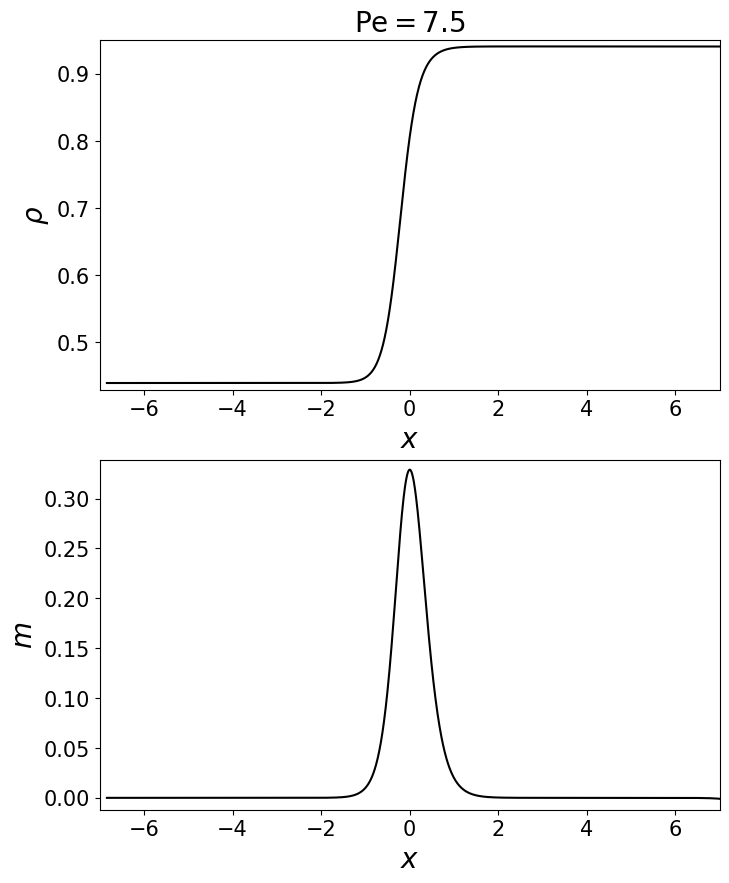

14.006874894558626


In [14]:
#find central time
t_mid_arg = argmax(sol[2,:])
t_middle = sol.t[t_mid_arg]
t_max = maximum(sol.t[:].-t_middle)
t_min = minimum(sol.t[:].-t_middle)
t_lim = round(min(t_max, - t_min))
t_lim_index = argmin(abs.(sol.t[:].-2*t_lim))
println(sol.t[t_lim_index])
#plot figure
PyPlot.close("all")
fig, axs = plt.subplots(2, 1, figsize=(8,10))
xlabels = [L"\rho", L"m"]
for i in 1:2
    ax = axs[i]
    ax.plot(sol.t[:].-t_middle, sol[i,:], color = "black")
    axlim = [ -t_lim, t_lim, minimum(sol[i,1:t_lim_index])-0.01, maximum(sol[i,1:t_lim_index])+0.01]
    ax.xaxis.set_tick_params(labelsize=15)
    ax.xaxis.tick_bottom()
    ax.yaxis.set_tick_params(labelsize=15)
    ax.axis(axlim)
    #ax.set_title(L"\Re{ \lambda_n^\mathrm{max}} = 0",fontsize=20)
    ax.set_ylabel(xlabels[i],fontsize=20)
    ax.set_xlabel(L"x",fontsize=20)
end
fig_title = latexstring("\$ \\mathrm{Pe} = $(Pe) \$")
axs[1].set_title(fig_title,fontsize=20)
display(fig)

In [4]:
function bump_funciton(x; ϵ = 1, x0 = 0.)
    if (-1<((x-x0)/ϵ)<1)
        return exp(-1/(1-((x-x0)/ϵ)^2))/ϵ
    else
        return 0
    end
end

function initialize_bin_pm(param::Dict{String,Any}; )
    @unpack name, D, λ, ρa, ρp, δt, Nx, Nθ, S,  E= param
    ϕa = ρa
    ϕp = ρp
    initial_Δ = 1e-4;
    max_iter = 40;
    tol = 1e-3;
    atol = 1e-12;
    rho_max = (1-10e-20);
    γ = (1-ϕa)/(1-ρ);

    find_sol, lower_limits, upper_limits = colapse_sol_interval(;Pe = Pe, γ = γ, rho_max = rho_max, initial_Δ = initial_Δ, max_iter = max_iter, tol = tol, atol = atol);
    ϕg = lower_limits[1]
    ϕl = upper_limits[1]

    ϕag, ϕpg = gamma_converter(γ, ϕg)
    ϕal, ϕpl = gamma_converter(γ, ϕl)

    density = Dict{String,Any}()
    fa = fill(ϕag/(2),(Nx,Nθ))
    fp = fill(ϕpg,(Nx))
    Nx2 = Int64(round(Nx/2))
    fa[1:Nx2,:] = fill(ϕal/(2),(Nx2,Nθ))
    fp[1:Nx2] = fill(ϕpl,(Nx2))
    t = 0.
    @pack! density = fa , fp, t
    return density
end

function smooth_density(param,density)
    @unpack name, Dx, Dθ, λ, ρa, ρp, δt, Nx, Nθ, S,  E= param
    @unpack t, fa, fp = density 
    
    mollifier = bump_funciton.((1:Nx)/Nx; ϵ = 5*sqrt(Dx/Dθ), x0 = 1/2)
    mollifier = mollifier/sum(mollifier)

    Nx2 = Int64(round(Nx/2))

    fa2 = zeros(Nx,2)
    fp2 = zeros(Nx)
    for i in 1:Nx, j in 1:Nx
        ## k = i - j 
        k = (i-j +Nx2 +Nx -1 )%Nx +1
        fa2[i,1] += mollifier[k].*fa[j,1]
        fa2[i,2] += mollifier[k].*fa[j,2]
        fp2[i]   += mollifier[k].*fp[j]
    end

    density = Dict{String,Any}()
    fa = fa2
    fp = fp2
    t = 0.
    @pack! density = fa , fp, t
    return density
end


function initialize_arctan_pm(param::Dict{String,Any}; )
    @unpack name, D, λ, ρa, ρp, δt, Nx, Nθ, S,  E= param
    ϕa = ρa
    ϕp = ρp
    ϕ = ϕa+ϕp
    initial_Δ = 1e-4;
    max_iter = 40;
    tol = 1e-3;
    atol = 1e-12;
    rho_max = (1-10e-20);
    γ = (1-ϕa)/(1-ϕ);

    find_sol, lower_limits, upper_limits = colapse_sol_interval(;Pe = Pe, γ = γ, rho_max = rho_max, initial_Δ = initial_Δ, max_iter = max_iter, tol = tol, atol = atol);
    ϕg = lower_limits[1]
    ϕl = upper_limits[1]

    ϕag, ϕpg = gamma_converter(γ, ϕg)
    ϕal, ϕpl = gamma_converter(γ, ϕl)


    l = sqrt(Dx/Dθ)
    ϵ = 2.0
    
    density = Dict{String,Any}()

    ρa  = (ϕal-ϕag)*(  tanh.( (collect(1:Nx)/Nx .-0.75)/ϵ/l )/2 .+0.5) .+ ϕag
    fp  = (ϕpl-ϕpg)*(tanh.( (collect(1:Nx)/Nx .-0.75)/ϵ/l )/2 .+0.5) .+ ϕpg
    ρ = ρa+fp

    m   = (ϕl-ϕg)*( -tanh.( (collect(1:Nx)/Nx .-0.75)/ϵ/l ).^2 .+1 )/2 ./(-ρ.+1)/λ/l/ϵ

    Nx2 = Int64(round(Nx/2))
    ρa[1:Nx2]  = -(ϕal-ϕag)*(  tanh.( (collect(1:Nx2)/Nx .-0.25)/ϵ/l )/2 .+0.5  ) .+ ϕal
    fp[1:Nx2] = -(ϕpl-ϕpg)*(tanh.( (collect(1:Nx2)/Nx .-0.25)/ϵ/l )/2 .+0.5  ) .+ ϕpl
    ρ = ρa+fp
    m[1:Nx2]  = -(ϕl-ϕg)*( -tanh.( (collect(1:Nx2)/Nx .-0.25)/ϵ/l ).^2 .+1 )/2 ./(-ρ[1:Nx2].+1)/λ/l/ϵ
    

    fa = zeros(Nx,2)
    fa[:,1] = (ρa - m)/2
    fa[:,2] = circshift((ρa + m)/2,0)
    t = 0.

    @pack! density = fa , fp, t
    return density
end


function initialize_sol_pm(param::Dict{String,Any}, sol, ϕg, ϕl, γ;)
   @unpack name, D, λ, ρa, ρp, δt, Nx, Nθ, S,  E= param
    γ = (1-ρa)/(1-ρa-ρp);
    #find central time
    t_mid_arg = argmax(sol[2,:])
    t_middle = sol.t[t_mid_arg]
    t_max = maximum(sol.t[:].-t_middle)
    t_min = minimum(sol.t[:].-t_middle)
    t_lim = round(min(t_max, - t_min))
    #t_lim_index = argmin(abs.(sol.t[:].-2*t_lim))
    
    l = sqrt(Dx/Dθ)
    density = Dict{String,Any}()
    
    ρ = fill(ϕg, Nx)
    m = fill(0., Nx)
    
    Nx4  = Int64(round(Nx/4))
    Nx2  = 2*Nx4
    Nx34 = 3*Nx4
    
    ρ[(Nx4+1):1:Nx34] = fill(ϕl, Nx2)
    
    n_index = min(Int64(round(t_lim*l*Nx)),Nx4)
    
    ts1 = collect((1:(2*n_index))/Nx/l) .+ sol.t[t_mid_arg] .-n_index/Nx/l
    ts2 = collect(((2*n_index):(-1):1)/Nx/l) .+ sol.t[t_mid_arg] .-n_index/Nx/l
    
    sol_index_1 = (Nx4-n_index+1):1:(Nx4+n_index)
    sol_index_2 = (Nx34-n_index+1):1:(Nx34+n_index)
    
    ρ[sol_index_1] = sol.(ts1, idxs = 1)
    m[sol_index_1] = sol.(ts1, idxs = 2)
    
    ρ[sol_index_2] =  sol.(ts2, idxs = 1)
    m[sol_index_2] = -sol.(ts2, idxs = 2)
    
    ρa = γ*(ρ .- 1) .+1
    fp = ρ - ρa
    fa = zeros(Nx,2)
    fa[:,1] = (ρa - m)/2
    fa[:,2] = (ρa + m)/2
    t = 0.
    
    @pack! density = fa , fp, t
    return density
end

function spatial_currents_pm(fa_saves, fp_saves; param = param)
    @unpack Nx, Nθ, ρa, ρp, χ, Dθ, Dx, k, γ,Pe,λ  = param
    ja_saves, jp_saves = [], []
    for i in eachindex(fa_saves)
        fa = fa_saves[i]
        fp =  fp_saves[i]

        ρ::Array{Float64,1} = fp + sum(fa; dims =2)[:,1]
    
        Ua::Array{Float64,2},   Up::Array{Float64,1} = U_velocities_pm(fa,fp,ρ; Nx=Nx, Nθ=Nθ, λ=λ,γ=γ)
        moba::Array{Float64,2}, mobp::Array{Float64,1} = mob_pm(fa,fp,ρ;γ=γ)
        Fa::Array{Float64,2},   Fp::Array{Float64,1}  = F_fluxes_pm(Ua, Up, moba, mobp; Nx=Nx, Nθ=Nθ)
        
        ja = sum(Fa; dims =2)[:,1]
        jp = Fp
        push!(ja_saves,ja)
        push!(jp_saves,jp)
    end
    return ja_saves, jp_saves
end

using DifferentialEquations

function f(du,u,parameters,t)
    Pe = parameters[1]
    γ = parameters[2]
    ϕ1 = parameters[3]
    du[1] = Pe*(1-u[1])*u[2]
    du[2] = -Pe*u[2]^2 + Pe*( (1-γ*(1-u[1]))*self_diff(u[1]) -(1-γ*(1-ϕ1))*self_diff(ϕ1) )/self_diff(u[1]) -(2/Pe)*log( (1-u[1])/(1-ϕ1) )/self_diff(u[1])
    return du
end

function f_jac(J,u,parameters,t)
    Pe = parameters[1]
    γ = parameters[2]
    ϕ1 = parameters[3]
    J[1,1] = -Pe*u[2]
    J[1,2] =  Pe*(1-u[1])
    J[2,1] =  self_diff_prime(u[1])*            (2/Pe)*log( (1-u[1])/(1-ϕ1) )/self_diff(u[1])^2              + (2/Pe)/(1-u[1])/self_diff(u[1])
    J[2,1] += self_diff_prime(u[1])*Pe*((1-γ*(1-u[1]))*self_diff(u[1]) -(1-γ*(1-ϕ1))*self_diff(ϕ1) )/self_diff(u[1])^2  + Pe*(γ*self_diff(u[1]) +(1-γ*(1-u[1]))*self_diff_prime(u[1]) )/self_diff(u[1])
    J[2,2] = -2*Pe*u[2]
    return J
end

function initialize_sol_pm_full(param::Dict{String,Any})
    @unpack name, D, λ, ρa, ρp, δt, Nx, Nθ, Pe, Dx, Dθ= param
    #copmute binodal values

    ϕa = ρa
    ϕp = ρp
    ϕ = ϕa+ϕp

    initial_Δ = 1e-4;
    max_iter = 40;
    tol = 1e-16;
    atol = 1e-16;
    rho_max = (1-10e-20);
    γ = (1-ϕa)/(1-ϕ);

    find_sol, lower_limits, upper_limits = colapse_sol_interval(;Pe = Pe, γ = γ, rho_max = rho_max, initial_Δ = initial_Δ, max_iter = max_iter, tol = tol, atol = atol);
    ϕg = lower_limits[1]
    ϕl = upper_limits[1]
    ϕg, ϕl 
    find_sol

    #compute solution
    J = zeros(2,2)
    u = zeros(2)
    parameters = (Pe, γ, ϕg, ϕl)
    t = 0.
    J = f_jac(J,u,parameters,t)
    values, vectors = eigen(J)
    evector2 = vectors[:,2]

    ff = ODEFunction(f;jac=f_jac)
    ϵ = 1e-15
    initial_position = [ϕg, 0.0] + ϵ*evector2
    time_interval = (0.0, 20.0)

    ff = ODEFunction(f;jac=f_jac)
    prob = ODEProblem(ff,initial_position,time_interval, parameters)

    sol = DifferentialEquations.solve(prob,abstol = 1e-14, reltol = 1e-14);

    #find central time
    t_mid_arg = argmax(sol[2,:])
    t_middle = sol.t[t_mid_arg]
    t_max = maximum(sol.t[:].-t_middle)
    t_min = minimum(sol.t[:].-t_middle)
    t_lim = round(min(t_max, - t_min))
    #t_lim_index = argmin(abs.(sol.t[:].-2*t_lim))
    
    l = sqrt(Dx/Dθ)
    density = Dict{String,Any}()
    
    ρ = fill(ϕg, Nx)
    m = fill(0., Nx)
    
    Nx4  = Int64(round(Nx/4))
    Nx2  = 2*Nx4
    Nx34 = 3*Nx4
    
    ρ[(Nx4+1):1:Nx34] = fill(ϕl, Nx2)
    
    n_index = min(Int64(round(t_lim*l*Nx)),Nx4)
    
    ts1 = collect((1:(2*n_index))/Nx/l) .+ sol.t[t_mid_arg] .-n_index/Nx/l
    ts2 = collect(((2*n_index):(-1):1)/Nx/l) .+ sol.t[t_mid_arg] .-n_index/Nx/l
    
    sol_index_1 = (Nx4-n_index+1):1:(Nx4+n_index)
    sol_index_2 = (Nx34-n_index+1):1:(Nx34+n_index)
    
    ρ[sol_index_1] = sol.(ts1, idxs = 1)
    m[sol_index_1] = sol.(ts1, idxs = 2)
    
    ρ[sol_index_2] =  sol.(ts2, idxs = 1)
    m[sol_index_2] = -sol.(ts2, idxs = 2)
    
    ρa = γ*(ρ .- 1) .+1
    fp = ρ - ρa
    fa = zeros(Nx,2)
    fa[:,1] = (ρa - m)/2
    fa[:,2] = (ρa + m)/2
    t = 0.
    
    @pack! density = fa , fp, t
    return density
end



initialize_sol_pm_full (generic function with 1 method)

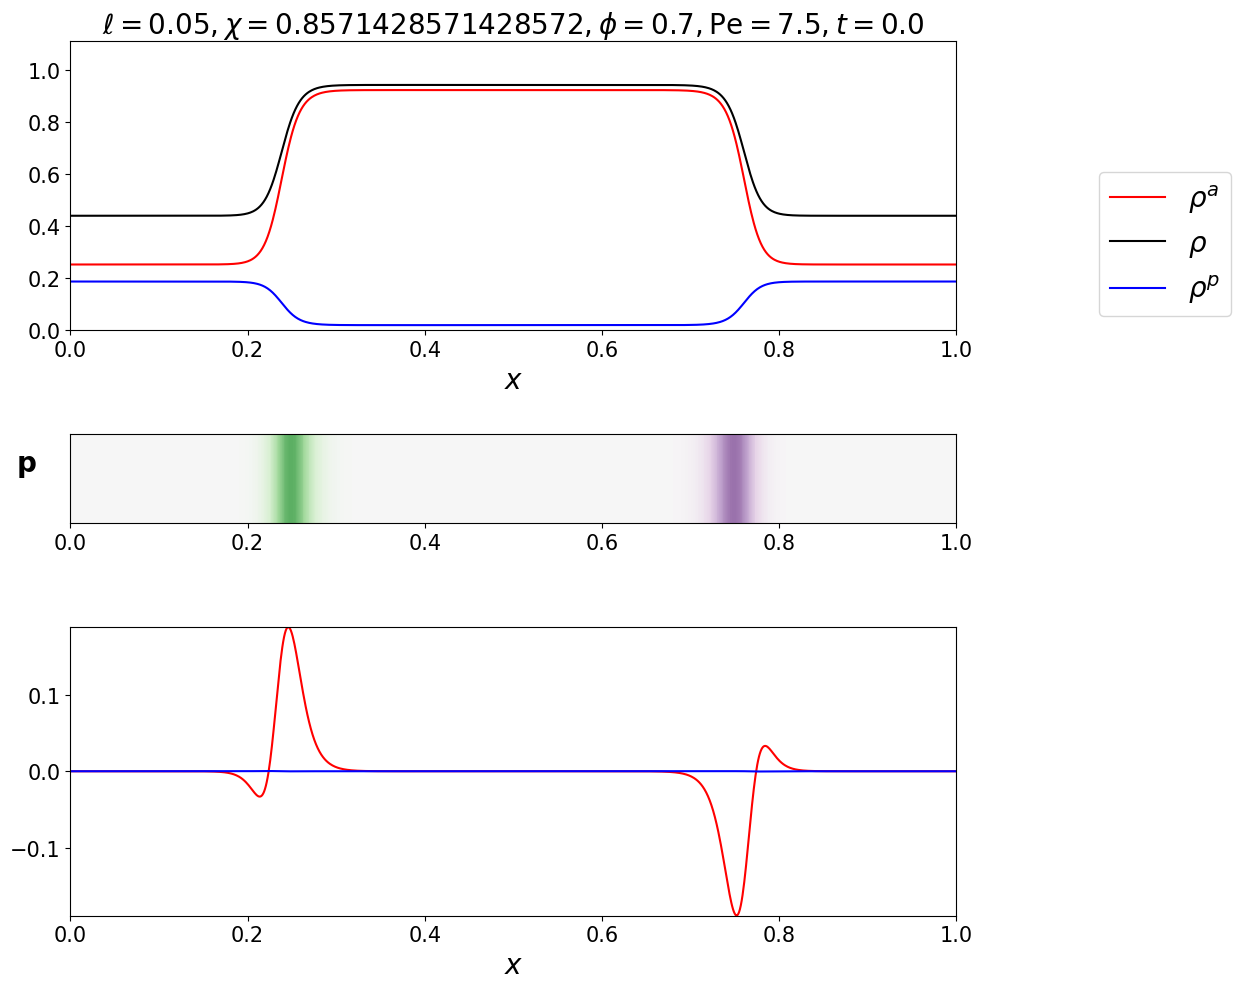

1024

In [5]:
#plot density 
using PyPlot
@unpack T, save_interval, max_steps, pert, Nx= param
Nx = 2^10
@pack! param = Nx
#density = initialize_sol_pm(param,sol,ϕg , ϕl, γ)
#density = smooth_density(param,density)
density = initialize_sol_pm_full(param)

@unpack t, fa, fp = density
# n = length(t_saves)
# t, fa, fp = t_saves[n], fa_saves[n], fp_saves[n]
fig, axs = plt.subplots(3, 1, figsize=(10,10))
vid_pde_plot_pm_plus(fig, axs, param, [t], [fa], [fp], 1)
display(fig)
Nx


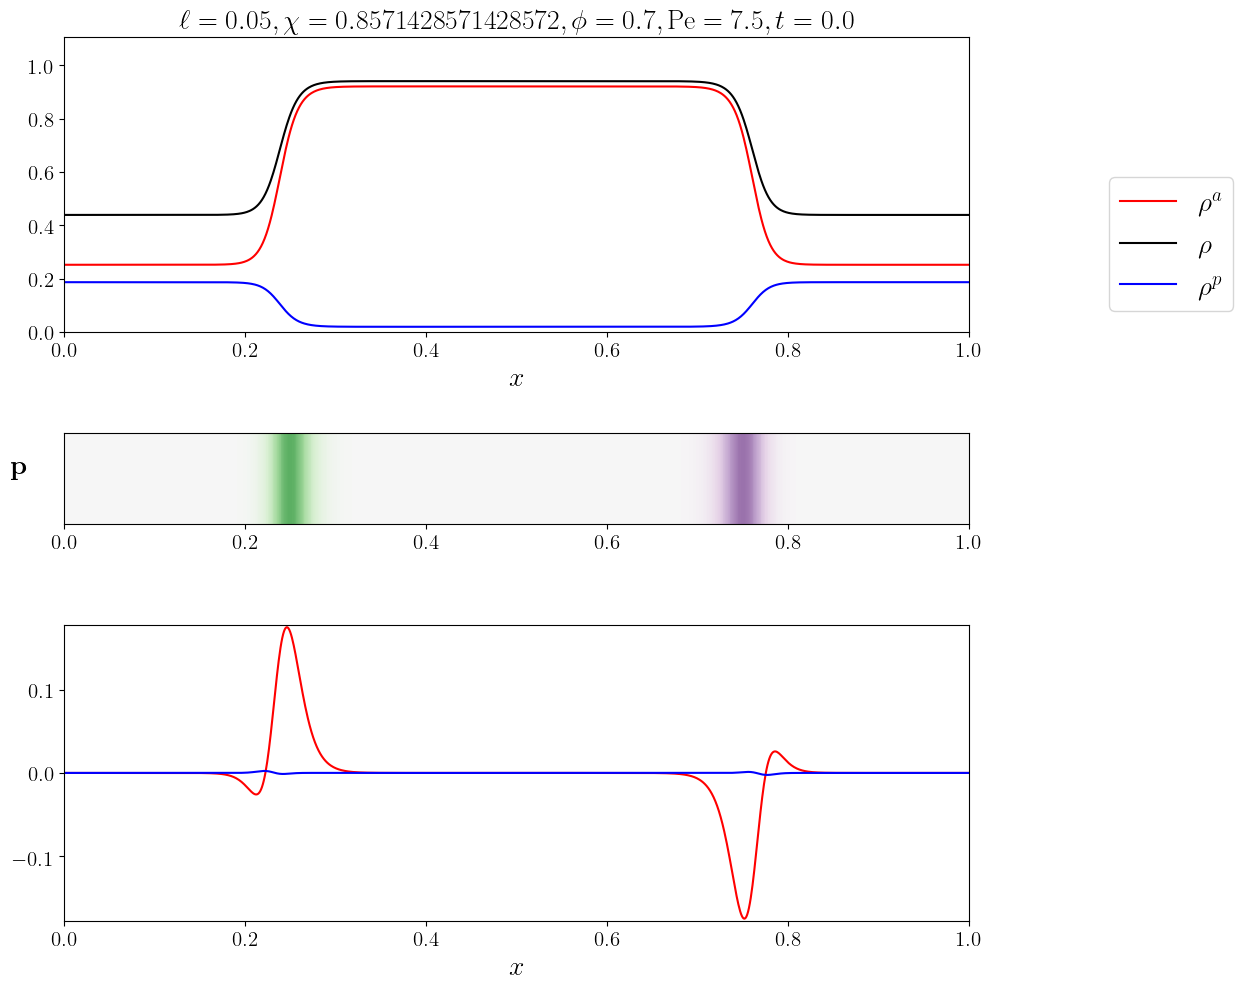

1024

In [386]:
@unpack t, fa, fp = density
# n = length(t_saves)
# t, fa, fp = t_saves[n], fa_saves[n], fp_saves[n]
fig, axs = plt.subplots(3, 1, figsize=(10,10))
vid_pde_plot_pm_plus(fig, axs, param, [t], [fa], [fp], 1)
display(fig)
Nx

In [387]:
t

1.1199999999999903e-5

In [385]:
for i in 1:100
    pde_stepper_pm!(param,density)
end


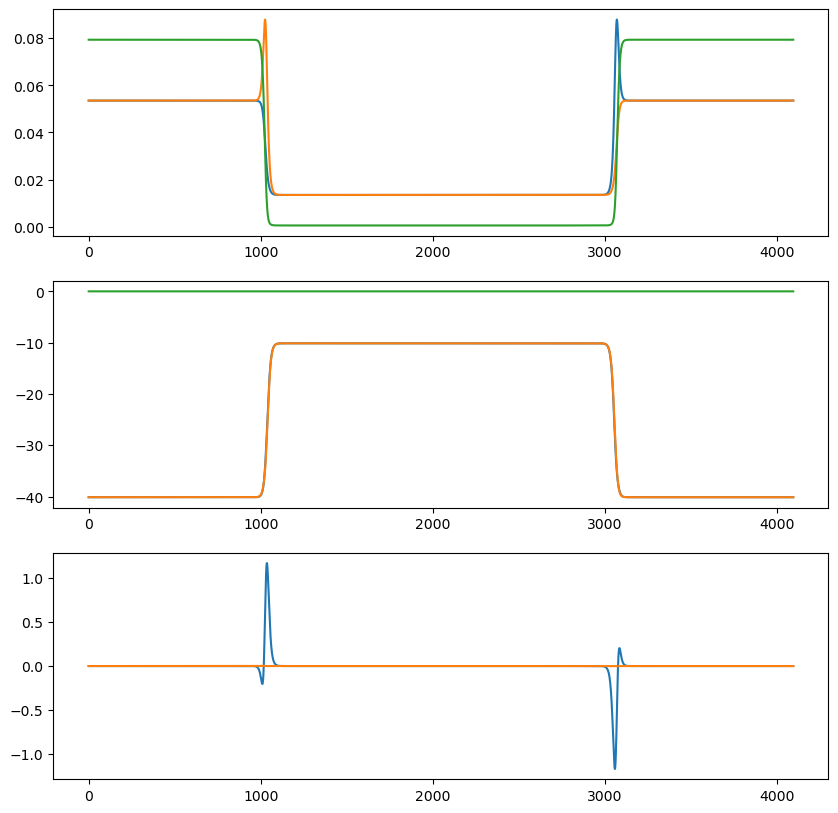

In [151]:
@unpack t, fa, fp = density
ρ = fp + sum(fa; dims =2)[:,1]

    @unpack Nx, Nθ, ρa, ρp, χ, Dθ, Dx, k, γ,Pe,λ  = param

    logtol = log(1e-10);

    eθ = reshape([-1 1],1,Nθ) 

    logmfa = map(x -> (x>0 ? log(x) : logtol), fa);
    logmfp = map(x -> (x>0 ? log(x) : logtol), fp);
    p_rho = p.(ρ;γ=γ) #functon p is labelled W in the pdf

    Ua   = -midpoint_bond_diff_θ_pm(logmfa .+ p_rho; Nx=Nx, Nθ=Nθ).+ λ*midpoint_bond_av_pm(coeff_mag_s_pm(fa,ρ; Nθ=Nθ, Nx=Nx,γ=γ ); Nx =Nx ) .+ λ*eθ 
    Up = -midpoint_bond_diff_pm(  logmfp  + p_rho; Nx=Nx       ) + λ*midpoint_bond_av_pm(coeff_mag_s_pm(fa,ρ; Nθ=Nθ, Nx=Nx,γ=γ ); Nx =Nx )

    moba, mobp = mob_pm(fa,fp,ρ;γ=γ)
    Fa,   Fp  = F_fluxes_pm(Ua, Up, moba, mobp; Nx=Nx, Nθ=Nθ)


    fig, axs = plt.subplots(3, 1, figsize=(10,10))

    ja = sum(Fa; dims =2)[:,1]
    jp = Fp

axs[1].plot(moba)
    axs[1].plot(mobp)
    axs[2].plot(Fa[:,1])
    axs[2].plot(-Fa[:,2])
    axs[2].plot(Fp)
    axs[3].plot(ja)
    axs[3].plot(jp)
display(fig)
Fa;

In [388]:
#run test
#perturb_pde_run_pm(param)
# @unpack T, save_interval, max_steps, pert = param
# density = initialize_bin_pm(param)
#perturb_pde_pm!(param,density; pert = pert, δ = δ);
T = 0.05
save_interval = 0.001
run_pde_until_pm!(param,density,T; save_on = true, max_steps = max_steps, save_interval = save_interval)


5000000

In [389]:
make_phase_video_pm(param; skip_factor = 1, ϕg =ϕg, ϕl = ϕl)

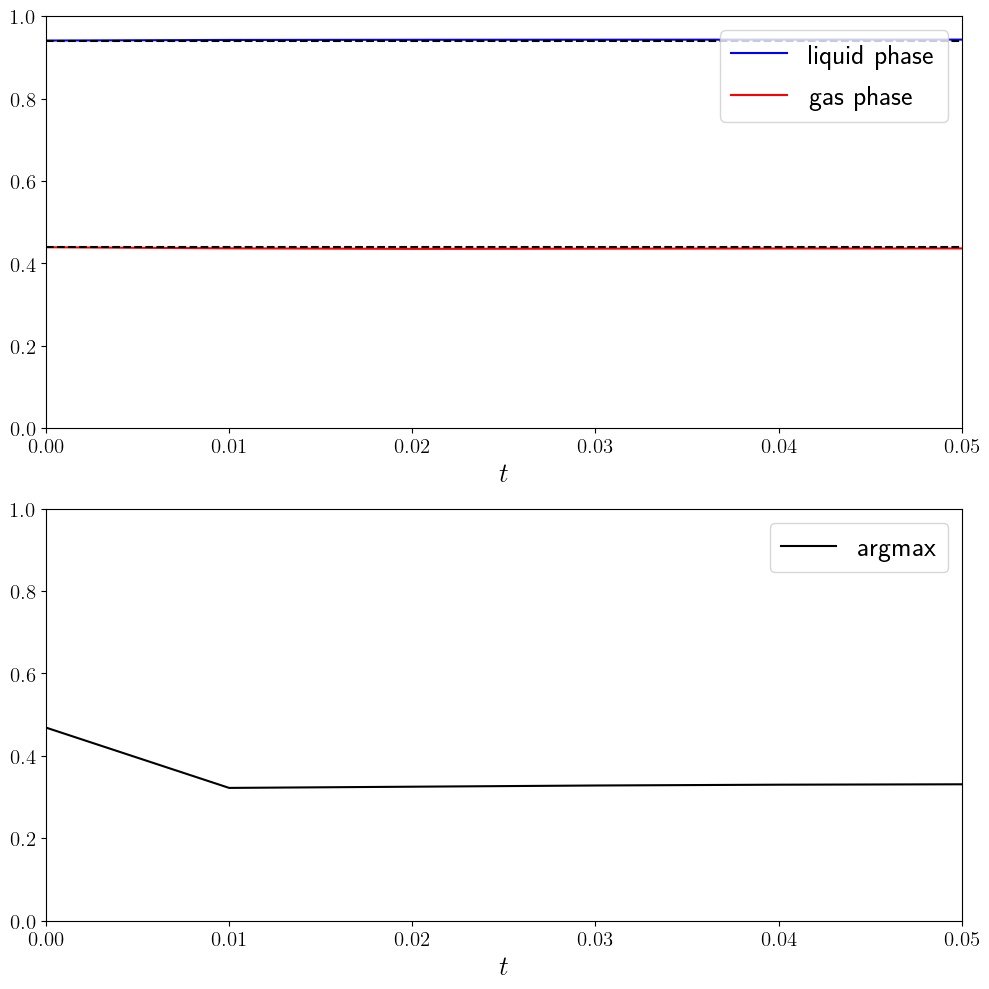

In [390]:
# load solution
function cal_rho_saves(fa, fp; Nθ = Nθ)
    return fp + sum(fa; dims =2)[:,1]
end
save_interval = 0.01
T= 1.0
t_saves, fa_saves, fp_saves = load_pdes_pm(param,T; save_interval = save_interval);
ρ_saves = cal_rho_saves.(fa_saves, fp_saves; Nθ = Nθ);
ρl_saves =  maximum.(ρ_saves);
ρg_saves =  minimum.(ρ_saves);
xmax_saves = argmax.(ρ_saves)/Nx;

#plot data
using PyPlot
    PyPlot.close("all")
    rc("text", usetex=true)
fig, axs = plt.subplots(2, 1, figsize=(10,10))

#plot binodal

ax = axs[1]
    N = length(t_saves)
    liquid = ax.plot(t_saves, ρl_saves, color = "blue", label = "liquid phase")
    gas = ax.plot(t_saves, ρg_saves, color = "red", label = "gas phase")
    binod_liquid = ax.plot(t_saves, ϕl*ones(N), color = "black", linestyle = "--", label = "_liquid phase")
    binod_gas = ax.plot(t_saves, ϕg*ones(N), color = "black",linestyle = "--", label = "_gas phase")
    #plot phase
    ax = axs[2]
ax.plot(t_saves, xmax_saves, color = "black", label = "argmax")

#axs settings
for ax in axs
    #ax.yaxis.set_ticks(ytic)
    axlim = [0, maximum(t_saves), 0, 1]
    #axlim = [0.4, 0.45, 0, 0.1]
    ax.xaxis.set_tick_params(labelsize=15)
    #ax.xaxis.tick_bottom(t_saves)
    ax.yaxis.set_tick_params(labelsize=15)
    ax.axis(axlim)
    #ax.set_title(L"\Re{ \lambda_n^\mathrm{max}} = 0",fontsize=20)
    ax.set_xlabel(L"t",fontsize=20)
    #ax.set_ylabel(L"\phi^p", fontsize=20)
    ax.legend(loc = "upper right", fontsize=20)
    #ax.set_aspect(0.25*Δρ/ΔPe)
end
fig.tight_layout()
display(fig)


In [89]:
#increase spacing
Nx = 512
T = 1.0
save_interval = 0.01
#
param = pde_param_pm(; name = name, 
                                ρ = ρ, Pe = Pe, χ = χ, T = T, 
                                Dθ = Dθ, δt = 1e-5, Nx = Nx, Nθ = Nθ, 
                                save_interval = save_interval, max_steps = 1e7,
                                pert = pert, δ = δ,
);

k = length(t_saves)
t, fa, fp = t_saves[k], fa_saves[k], fp_saves[k]

new_fa, new_fp = zeros(2*Nx,2), zeros(2*Nx)

new_fa[1:2:(2*Nx),:], new_fp[1:2:(2*Nx)] = deepcopy(fa), deepcopy(fp)
new_fa[2:2:(2*Nx),:], new_fp[2:2:(2*Nx)] = deepcopy(fa), deepcopy(fp)

new_fa[2:2:(2*Nx-2),:], new_fp[2:2:(2*Nx-2)] = new_fa[1:2:(2*Nx-2),:]/2+new_fa[3:2:(2*Nx),:]/2, new_fp[2:2:(2*Nx-2)]/2 + new_fp[3:2:(2*Nx)]/2
new_fa[2*Nx,:], new_fp[2*Nx] = new_fa[1,:]/2+ new_fa[2*Nx-1,:]/2, new_fp[1]/2 + new_fp[2*Nx-1]/2


fa, fp = new_fa, new_fp

Nx = 1024
T = 2.0
save_interval = 0.0001
#
param = pde_param_pm(; name = name, 
                                ρ = ρ, Pe = Pe, χ = χ, T = T, 
                                Dθ = Dθ, δt = 1e-5, Nx = Nx, Nθ = Nθ, 
                                save_interval = save_interval, max_steps = 1e7,
                                pert = pert, δ = δ,
);
#
@pack! density = t, fa, fp

(0.9800485645776547, [0.12280102266608624 0.12280102700956716; 0.12280102140084981 0.12280103008797172; … ; 0.12280102700956716 0.12280102266608624; 0.1228010248378267 0.1228010248378267], [0.18908089722643656, 0.18908089856375165, 0.18908089990106675, 0.18908090257567325, 0.18908090525027976, 0.18908090926212973, 0.1890809132739797, 0.18908091862299964, 0.18908092397201956, 0.18908093065810866  …  0.18908092397201956, 0.18908091862299964, 0.1890809132739797, 0.18908090926212973, 0.18908090525027976, 0.18908090257567325, 0.18908089990106675, 0.18908089856375165, 0.18908089722643656, 0.18908089722643656])

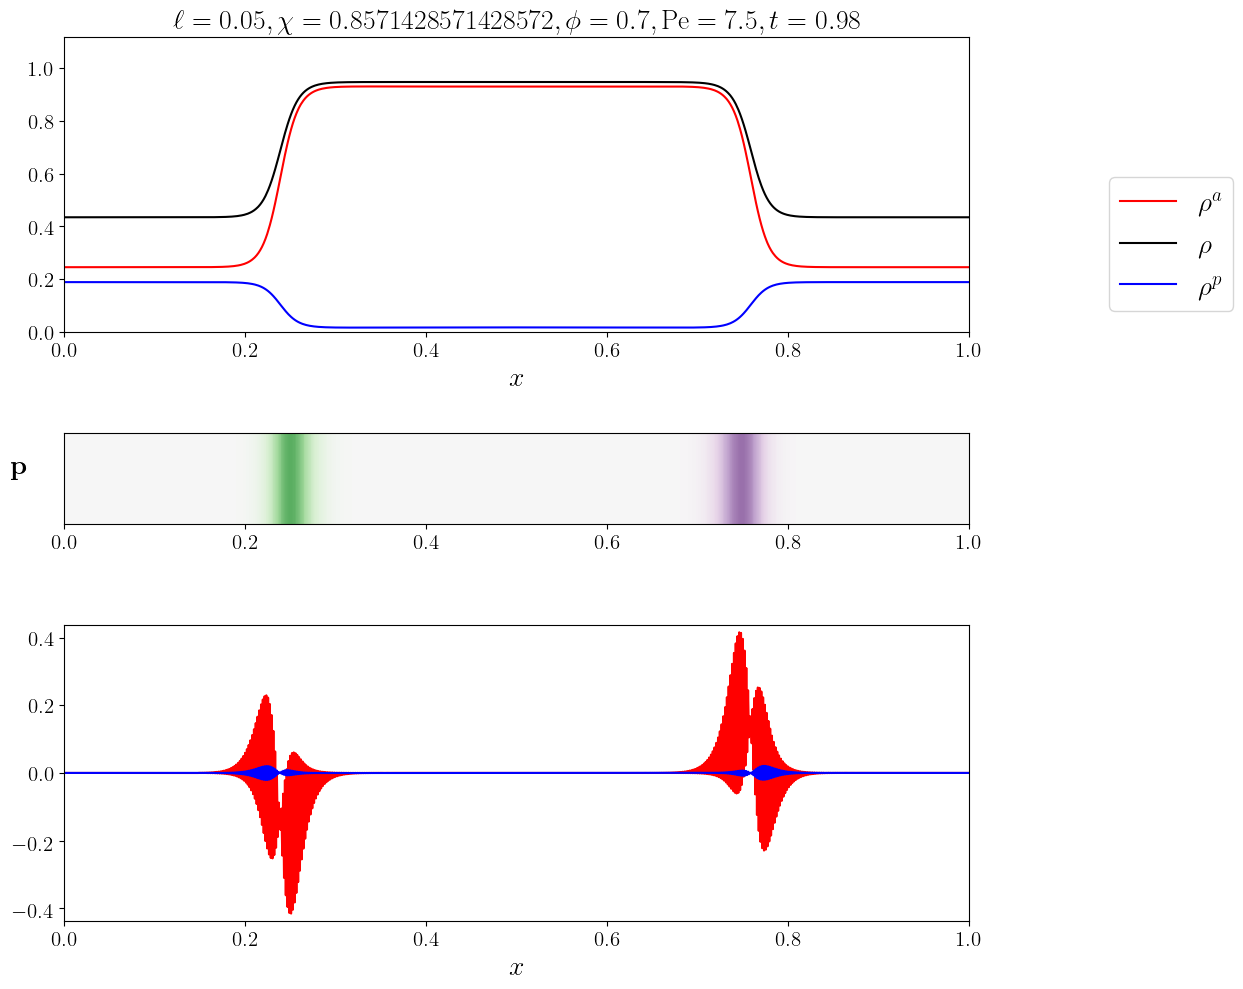

In [90]:
fig, axs = plt.subplots(3, 1, figsize=(10,10))
vid_pde_plot_pm_plus(fig, axs, param, [t], [fa], [fp], 1)
display(fig)

In [81]:
T = 1.1
save_interval = 0.001
run_pde_until_pm!(param,density,T; save_on = true, max_steps = max_steps, save_interval = save_interval)

250569

In [83]:
make_phase_video_pm(param; skip_factor = 1, ϕg =ϕg, ϕl = ϕl, start_time = 1.0)